In [4]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from datetime import datetime
import random


import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# supress pytorch warnings
import warnings

warnings.filterwarnings("ignore")

## Pre-trained GoogleNet on HAM10000

In [29]:
# set random seed
torch.manual_seed(12)
random.seed(12)
np.random.seed(12)

metadata_file = "HAM10000_metadata.csv"
image_folder = "HAM10000_images_merged"

mapping = {'akiec': 0,
           'bcc': 1,
           'bkl': 2,
           'df': 3,
           'mel': 4,
           'nv': 5,
           'vasc': 6
           }

train_ratio = 0.6
test_ratio = 0.2
val_ratio = 0.2

num_epochs = 1
batch_size = 4
learning_rate = 1e-4

CHEAT = True

# check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available!")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available!")
else:
    device = torch.device("cpu")
    print("Use CPU only.")

original_label = pd.read_csv(metadata_file)
shuffled_label = original_label.sample(frac=1).reset_index(drop=True, inplace=False)


class SkinLesionDataset(Dataset):
    def __init__(self, shuffled_label, img_dataset_path, normalization=None, transform=None, target_transform=None):
        self.shuffled_label = shuffled_label
        self.lesion_id = self.shuffled_label.iloc[:, 0].tolist()
        self.image_id = self.shuffled_label.iloc[:, 1].tolist()
        self.dx = self.shuffled_label.iloc[:, 2].tolist()
        self.dx_type = self.shuffled_label.iloc[:, 3].tolist()
        self.age = self.shuffled_label.iloc[:, 4].tolist()
        self.sex = self.shuffled_label.iloc[:, 5].tolist()
        self.localization = self.shuffled_label.iloc[:, 6].tolist()

        self.label = []
        for type in self.dx:
            self.label.append(mapping[type])

        self.img_dataset_path = img_dataset_path
        self.img_paths = []
        for filename in self.image_id:
            self.img_paths.append(os.path.join(os.getcwd(), self.img_dataset_path, filename + ".jpg"))

        self.normalization = normalization
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        pixel = read_image(img_path)
        label = self.label[idx]
        if self.normalization:
            pixel = self.normalization(pixel)
        if self.transform:
            pixel = self.transform(pixel)
        if self.target_transform:
            label = self.target_transform(label)
        return pixel, label


def train_test_val_split(shuffled_label, type):
    total_samples = len(shuffled_label)
    train_samples = shuffled_label[0:int(train_ratio * total_samples)]
    test_samples = shuffled_label[int(train_ratio * total_samples): int((train_ratio + test_ratio) * total_samples)]
    val_samples = shuffled_label[int((train_ratio + test_ratio) * total_samples):
                                 int((train_ratio + test_ratio + val_ratio) * total_samples)]

    if type == 'train':
        train_dataset = SkinLesionDataset(shuffled_label=train_samples, img_dataset_path=image_folder,
                                          normalization=(lambda x: x / 255.0),
                                          transform=None,
                                          target_transform=None)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        return train_loader

    if type == 'test':
        test_dataset = SkinLesionDataset(shuffled_label=test_samples, img_dataset_path=image_folder,
                                         normalization=(lambda x: x / 255.0),
                                         transform=None,
                                         target_transform=None)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        return test_loader

    if type == 'val':
        val_dataset = SkinLesionDataset(shuffled_label=val_samples, img_dataset_path=image_folder,
                                        normalization=(lambda x: x / 255.0),
                                        transform=None,
                                        target_transform=None)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        return val_loader


train_loader = train_test_val_split(shuffled_label, "train")
test_loader = train_test_val_split(shuffled_label, "test")
val_loader = train_test_val_split(shuffled_label, "val")

MPS is available!


## Load Pre-trained model from PyTorch

In [30]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model.eval()

Using cache found in /Users/kko/.cache/torch/hub/pytorch_vision_v0.10.0


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [31]:
num_classes = len(mapping)
print(model.fc.in_features)
print(model.fc.out_features)

for param in model.parameters():
    param.requires_grad=True

1024
1000


In [32]:
n_inputs = model.fc.in_features
last_layer = nn.Linear(n_inputs,num_classes)
model.fc = last_layer

# Check for MPS and move the model to MPS if available
if torch.backends.mps.is_available():
    device = torch.device('mps')

model = model.to(device)
# Check to see the last layer produces the expected number of outputs
print(model.fc.out_features)

7


In [33]:
# loss function and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Model Training

In [34]:

# Define accuracy function
def calculate_accuracy(output, target):
    _, preds = torch.max(output, 1)
    return torch.sum(preds == target).item() / len(target)

# Train the model
def train(n_epochs, loaders, model, optimizer, criterion, use_mps, save_path):
    '''returns trained model and histories of training and validation losses and accuracies'''
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.inf

    # Initialize lists to track history of training and validation losses and accuracies
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(1, n_epochs+1):
        # Initialize variables to monitor training and validation loss and accuracy
        train_loss = 0.0
        valid_loss = 0.0
        train_corrects = 0
        valid_corrects = 0
        train_samples = 0
        valid_samples = 0

        # Model training
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # Move to MPS if available
            if use_mps:
                data, target = data.to('mps'), target.to('mps')
            else:
                data, target = data.to('cuda' if torch.cuda.is_available() else 'cpu'), target.to('cuda' if torch.cuda.is_available() else 'cpu')

            # Clear (zero out) the gradients of all optimized variables
            optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Perform optimization step (parameter update)
            optimizer.step()
            # Record the average training loss
            train_loss += loss.item()
            # Calculate the number of correct predictions
            train_corrects += calculate_accuracy(output, target) * data.size(0)
            train_samples += data.size(0)

        # Calculate average training loss and accuracy
        train_loss = train_loss / len(loaders['train'])
        train_accuracy = train_corrects / train_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Model validation
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # Move to MPS if available
            if use_mps:
                data, target = data.to('mps'), target.to('mps')
            else:
                data, target = data.to('cuda' if torch.cuda.is_available() else 'cpu'), target.to('cuda' if torch.cuda.is_available() else 'cpu')

            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update the average validation loss
            valid_loss += loss.item()
            # Calculate the number of correct predictions
            valid_corrects += calculate_accuracy(output, target) * data.size(0)
            valid_samples += data.size(0)

        # Calculate average validation loss and accuracy
        valid_loss = valid_loss / len(loaders['valid'])
        valid_accuracy = valid_corrects / valid_samples
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        # Print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f} \tTraining Accuracy: {:.5f} \tValidation Accuracy: {:.5f}'.format(
            epoch,
            train_loss,
            valid_loss,
            train_accuracy,
            valid_accuracy))

        # Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.5f} --> {:.5f}). Saving model ...'.format(
                  valid_loss_min,
                  valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    # Return trained model and histories
    return model, train_losses, valid_losses, train_accuracies, valid_accuracies

use_mps = torch.backends.mps.is_available()
# Define loaders transfer
loaders_transfer = {'train': train_loader,
                    'valid': val_loader,
                    'test': test_loader}

# Train the model
model_transfer, train_losses, valid_losses, train_accuracies, valid_accuracies = train(50, loaders_transfer, model, optimizer, criterion, use_mps, 'model_transfer.pt')

Epoch: 1 	Training Loss: 0.89703 	Validation Loss: 0.76802 	Training Accuracy: 0.69346 	Validation Accuracy: 0.72192
Validation loss decreased (inf --> 0.76802). Saving model ...
Epoch: 2 	Training Loss: 0.74913 	Validation Loss: 0.70694 	Training Accuracy: 0.74006 	Validation Accuracy: 0.75686
Validation loss decreased (0.76802 --> 0.70694). Saving model ...
Epoch: 3 	Training Loss: 0.65195 	Validation Loss: 0.62310 	Training Accuracy: 0.76718 	Validation Accuracy: 0.77534
Validation loss decreased (0.70694 --> 0.62310). Saving model ...
Epoch: 4 	Training Loss: 0.58318 	Validation Loss: 0.67168 	Training Accuracy: 0.79581 	Validation Accuracy: 0.76435
Epoch: 5 	Training Loss: 0.52161 	Validation Loss: 0.59319 	Training Accuracy: 0.81361 	Validation Accuracy: 0.80280
Validation loss decreased (0.62310 --> 0.59319). Saving model ...
Epoch: 6 	Training Loss: 0.46108 	Validation Loss: 0.54720 	Training Accuracy: 0.83458 	Validation Accuracy: 0.80479
Validation loss decreased (0.59319 -->

In [35]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

### Performance Visualizations

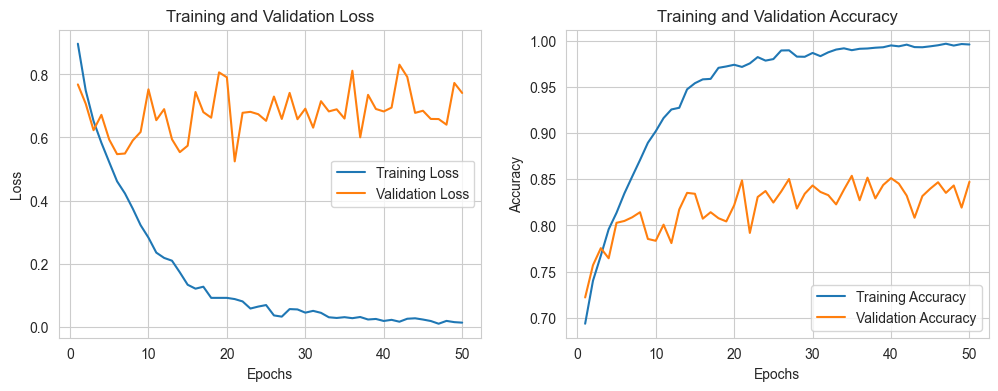

In [36]:
# Plot the results
epochs = range(1, 51)

plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

## Test-Data Performance

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def test(loaders, model, criterion, use_mps):
    # Initialize lists to track history of test losses and accuracies
    test_losses = []
    test_accuracies = []

    # Lists to store all predictions and true labels
    all_preds = []
    all_labels = []

    # Monitor test loss and accuracy
    test_loss = 0.0
    correct = 0.0
    total = 0.0

    model.eval()  # Set model to evaluation mode
    # Iterating over test data
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # Move to MPS if available
        if use_mps:
            data, target = data.to('mps'), target.to('mps')
        else:
            data, target = data.to('cuda' if torch.cuda.is_available() else 'cpu'), target.to('cuda' if torch.cuda.is_available() else 'cpu')

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Calculate the loss
        loss = criterion(output, target)
        # Update average test loss
        test_loss += loss.item()
        # Convert output probabilities to predicted class
        preds = output.data.max(1, keepdim=True)[1]
        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())
        # Compare predictions to true label
        correct += np.sum(np.squeeze(preds.eq(target.data.view_as(preds))).cpu().numpy())
        total += data.size(0)

    # Calculate average test loss and accuracy
    test_loss = test_loss / len(loaders['test'])
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print('Test Loss: {:.6f}'.format(test_loss))
    print('Test Accuracy: {:.2f}% ({}/{})'.format(100. * test_accuracy, int(correct), int(total)))

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print('Confusion Matrix:\n', cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    return test_losses, test_accuracies


Test Loss: 0.551933
Test Accuracy: 85.07% (1704/2003)
Confusion Matrix:
 [[  36    7   17    1    6    0    0]
 [   1   80    7    1    4    3    2]
 [   4    6  176    1   24   28    0]
 [   0    2    4   11    1    3    0]
 [   3    3   12    2  153   49    6]
 [   4   16   22    3   47 1222    6]
 [   0    0    1    1    0    2   26]]


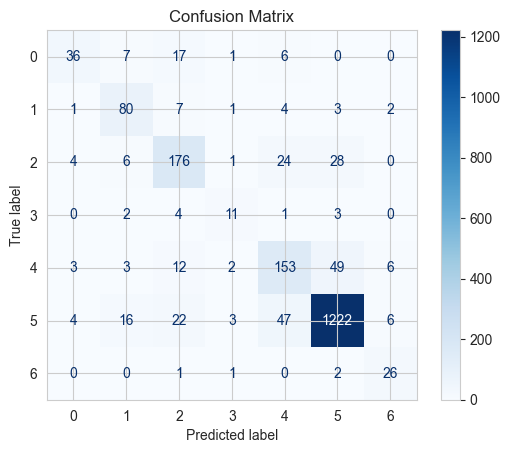

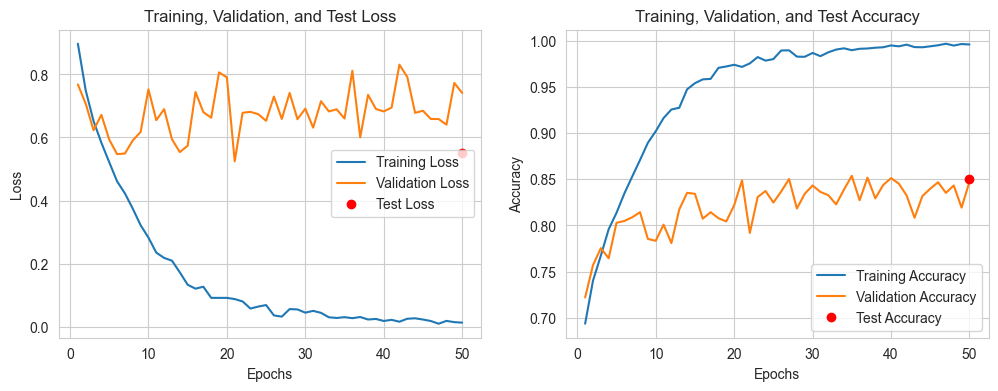

In [38]:
# Call test function and store history
test_losses, test_accuracies = test(loaders_transfer, model_transfer, criterion, use_mps)

# Plot the results including test data
epochs = range(1, 51)

plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.plot([50], test_losses, 'ro', label='Test Loss')  # Test loss is only for the last epoch
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training, Validation, and Test Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
plt.plot([50], test_accuracies, 'ro', label='Test Accuracy')  # Test accuracy is only for the last epoch
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training, Validation, and Test Accuracy')

plt.show()